# Project: NIP
# Subroject: Sylhet Floods, June 2022
## Script: calc_accuracyVsLabel.ipynb
This script evaluates the flood mapping algorithms against the hand labels. It computes metrics for specified image dates and sources.

In [1]:
from pathlib import Path
import os
import sys
import pandas as pd
import numpy as np
import rasterio
import matplotlib.pyplot as plt
from rasterio.plot import show
from rasterio.mask import mask
from itertools import chain
from pyproj import Transformer
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
import matplotlib.colors as colors
from datetime import datetime
import geopandas as gpd
import copy
import collections
from shapely.geometry import mapping
import pycrs
from shapely.geometry import Polygon
from functools import reduce
import shutil

In [2]:
# Set the root path
rootPath = Path('Z:/media/mule/Projects/NASA/NIP/Data')

In [3]:
# Add path for the Helpers modules
module_path = os.path.abspath(os.path.join('C:/Users/alexsaunders/Documents/01_uoa/04_git/NIP/Sylhet/'))
if module_path not in sys.path:
    sys.path.append(module_path)

In [4]:
# Import module from analyse_modifiedDevries containing helpful functions to use
import importlib
import Helpers.analyse_modifiedDevries as analyse_DV
importlib.reload(analyse_DV)
import Helpers.prepare_flood_raster as prep_raster
importlib.reload(prep_raster)

<module 'Helpers.prepare_flood_raster' from 'C:\\Users\\alexsaunders\\Documents\\01_uoa\\04_git\\NIP\\Sylhet\\Helpers\\prepare_flood_raster.py'>

## PART 1: Get the label data

In [5]:
# Move the mosaic NASSA IMPACT predictions to a single folder
labelPath = rootPath/'Raster/SylhetLabels/v2/finalLabels'

In [6]:
labelFiles = [file for file in list(labelPath.iterdir()) if file.suffix=='.tif']

In [7]:
labelDates = list(np.unique([item.stem.split('_')[0] for item in labelFiles]))

In [8]:
labelDates

['20220524', '20220530', '20220714']

## PART 2: Load the map data for scorign against labels

In [9]:
# Open the GFM mosaiced raster files and get the image dates
GFMPath = rootPath/'Raster/SylhetCopernicusGFM/sylhet_district_2022-05-01-2022-08-31/Mosaic'
GFM_mosaics = [file for file in (GFMPath).iterdir() if file.is_file() and '2022' in str(file)]
GFM_dates = [str(datetime.strptime(mosaic.stem[-10:].replace('_',''), '%Y%m%d').date()) for mosaic in GFM_mosaics]
print('GFM image dates: ', GFM_dates)

GFM image dates:  ['2022-05-01', '2022-05-11', '2022-05-13', '2022-05-23', '2022-05-25', '2022-06-04', '2022-06-06', '2022-06-16', '2022-06-18', '2022-06-28', '2022-06-30', '2022-07-12', '2022-07-22', '2022-07-24', '2022-08-05', '2022-08-15', '2022-08-27', '2022-08-29']


In [10]:
# Open the modified Devries mosaiced raster files and get the image dates
DevriesPath = rootPath/'Raster/Sylhet/Sen1MitchellSingleOrbit/Mosaic'
Devries_mosaics = [file for file in (DevriesPath).iterdir() if file.is_file() and '2022' in str(file)]
Devries_dates = [str(datetime.strptime(mosaic.stem[-14:-6], '%Y%m%d').date()) for mosaic in Devries_mosaics]
print('Modified DeVries image dates: ', Devries_dates)

Modified DeVries image dates:  ['2022-05-01', '2022-05-11', '2022-05-13', '2022-05-23', '2022-05-25', '2022-06-04', '2022-06-06', '2022-06-16', '2022-06-18', '2022-06-28', '2022-06-30', '2022-07-12', '2022-07-22', '2022-07-24', '2022-08-03', '2022-08-05', '2022-08-15', '2022-08-27', '2022-08-29']


In [11]:
# Open the UNOSAT raster files and get the image dates
UNOSATPath = rootPath/'Raster/SylhetUNOSAT'
UNOSAT_mosaics = [file for file in (UNOSATPath).iterdir() if file.is_file() and 'allTouchFalse' in str(file)]
UNOSAT_mosaics.reverse()
UNOSAT_dates = ['2022-05-25','2022-06-19']
print('UNOSAT image dates: ', UNOSAT_dates)

UNOSAT image dates:  ['2022-05-25', '2022-06-19']


In [12]:
# Open the NASA IMPACT raster files and get the image dates
IMPACTPath = rootPath/'Raster/SylhetNASAImpact/5_Preds/Mosaic/v2'
IMPACT_mosaics = [file for file in (IMPACTPath).iterdir() if file.is_file() and '2022' in str(file) and file.suffix=='.tif']
IMPACT_dates = [str(datetime.strptime(file.stem, '%Y%m%d').date()) for file in IMPACT_mosaics]
print('NASA IMPACT image dates: ', IMPACT_dates)

NASA IMPACT image dates:  ['2022-05-01', '2022-05-11', '2022-05-13', '2022-05-23', '2022-05-25', '2022-06-04', '2022-06-06', '2022-06-16', '2022-06-18', '2022-06-28', '2022-06-30', '2022-07-12', '2022-07-22', '2022-07-24', '2022-08-03', '2022-08-05', '2022-08-15', '2022-08-27', '2022-08-29']


## PART 3: Comparisons

### Dates to compare

Compare 20220524 label with 2022-05-25 (and maybe also 2022-05-23)?

Compare 20220530 label with 2022-06-04 (quite a big time difference?)

Compare 20220714 label with 2022-07-12

### Compare on a label by label basis
I.e., compute accuracy for a single label

In [25]:
# Function to compare a given map with a given label and retrun a list of confusion matrix metrics
# ['TN', 'FP', 'FN', 'TP', 'Precision', 'Recall', 'Accuracy', 'IOU']
def compare_map_wLabel(labelFile, mapRasterFile):
    
    # Get the label date and tileID
    labelDate=labelFile.stem.split('_')[0]
    labelTile='_'.join(labelFile.stem.split('_')[1:3])
    
    # Open the label raster
    labelRaster = prep_raster.load_label_for_comparison(str(labelFile))
    
    # Open the map to compare, and reproject and match the extent
    mapRaster = prep_raster.load_raster_for_comparison(str(mapRasterFile), 0)
    mapRasterReproj = prep_raster.reproj_match_raster(mapRaster, labelRaster)
    
    # Convert rasters to numpy arrays, make binary integers
    labelValues = prep_raster.raster_to_binary_list(labelRaster)
    mapValues = prep_raster.raster_to_binary_list(mapRasterReproj)
    
    # Run the function to get the confusion matrix and other metrics
    metrics_list = analyse_DV.get_confusion_matrix_metrics(labelValues, mapValues)
    
    return [labelDate, labelTile] + metrics_list

In [19]:
# Set up empty dataframe for saving results
confus_matrix_metrics = pd.DataFrame(data = [], index = ['MapSource', 'MapDate', 'labelDate', 'labelTile', 'TN', 'FP', 'FN', 'TP', 'Precision', 'Recall', 'Accuracy', 'IOU']).T

#### Perform on first set of labels from 20220524

In [38]:
# Define the date for the label and date for the nearest S1 images
labelDate = labelDates[0]
compareDate = '20220525'

In [39]:
# Get the labels on the given date
labelDateFiles = [file for file in labelFiles if labelDate in str(file)]

In [40]:
# Get the Devries, GFM and NASAIMPACT rasters to comapre, from the closest date
DevriesCompare = [file for file in Devries_mosaics if compareDate in str(file)][0]
GFMCompare = [file for file in GFM_mosaics if str(datetime.strptime(compareDate, '%Y%m%d').date()).replace('-','_') in str(file)][0]
IMPACTCompare = [file for file in IMPACT_mosaics if compareDate in str(file)][0]

In [53]:
# Loop through the labels, get the metrics and append to the dataframe
for i, labelDateFile in enumerate(labelDateFiles):
    
    # Get metrics for Devries
    confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['Devries',compareDate]+list(compare_map_wLabel(labelDateFile, DevriesCompare))], 
                                                                      columns=confus_matrix_metrics.columns), ignore_index=True)
    # Get metrics for GFM
    confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['GFM',compareDate]+list(compare_map_wLabel(labelDateFile, GFMCompare))], 
                                                                      columns=confus_matrix_metrics.columns), ignore_index=True)
    # Get metrics for NASA IMPACT
    confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['NASAIMPACT',compareDate]+list(compare_map_wLabel(labelDateFile, IMPACTCompare))], 
                                                                      columns=confus_matrix_metrics.columns), ignore_index=True)

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_11500\408422246.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['Devries',compareDate]+list(compare_map_wLabel(labelDateFile, DevriesCompare))],
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_11500\408422246.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['GFM',compareDate]+list(compare_map_wLabel(labelDateFile, GFMCompare))],
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_11500\408422246.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['N

In [13]:
# THIS ONE BELOW IS DONE WITH LATEST LABELS

In [54]:
confus_matrix_metrics

,MapSource,MapDate,labelDate,labelTile,TN,FP,FN,TP,Precision,Recall,Accuracy,IOU
0,Devries,20220525,20220524,11_4,313256.0,34972.0,258671.0,441677.0,0.926629,0.630654,0.719960,0.600660
1,GFM,20220525,20220524,11_4,346205.0,2023.0,425232.0,275116.0,0.992700,0.392828,0.592538,0.391696
2,NASAIMPACT,20220525,20220524,11_4,339119.0,9109.0,282239.0,418109.0,0.978678,0.597002,0.722149,0.589337
3,Devries,20220525,20220524,11_8,58806.0,12905.0,194280.0,782585.0,0.983777,0.801119,0.802413,0.790674
4,GFM,20220525,20220524,11_8,68081.0,3630.0,413120.0,563745.0,0.993602,0.577096,0.602556,0.574960
5,NASAIMPACT,20220525,20220524,11_8,62701.0,9010.0,210765.0,766100.0,0.988376,0.784243,0.790406,0.777076
6,Devries,20220525,20220524,12_5,383160.0,46404.0,92772.0,526240.0,0.918965,0.850129,0.867271,0.790844
7,GFM,20220525,20220524,12_5,427312.0,2252.0,261808.0,357204.0,0.993735,0.577055,0.748173,0.574963
8,NASAIMPACT,20220525,20220524,12_5,419294.0,10270.0,105189.0,513823.0,0.980404,0.830070,0.889890,0.816523
9,Devries,20220525,20220524,13_3,294093.0,28402.0,376877.0,349204.0,0.924784,0.480944,0.613496,0.462839


In [55]:
# # Write out the confusion matrix metrics as csv
# confus_matrix_metrics.to_csv(rootPath/'Table/SylhetConfusionMatrix/confusMatrixVsLabels_20220524.csv',index=False)

#### Perform on second set of labels from 20220530

In [26]:
labelDates[1]

'20220530'

In [27]:
# Define the date for the label and date for the nearest S1 images
labelDate = labelDates[1]
compareDate = '20220604'

In [28]:
# Get the labels on the given date
labelDateFiles = [file for file in labelFiles if labelDate in str(file)]

In [29]:
# Get the Devries, GFM and NASAIMPACT rasters to comapre, from the closest date
DevriesCompare = [file for file in Devries_mosaics if compareDate in str(file)][0]
GFMCompare = [file for file in GFM_mosaics if str(datetime.strptime(compareDate, '%Y%m%d').date()).replace('-','_') in str(file)][0]
IMPACTCompare = [file for file in IMPACT_mosaics if compareDate in str(file)][0]

In [30]:
# Loop through the labels, get the metrics and append to the dataframe
for i, labelDateFile in enumerate(labelDateFiles):
    
    # Get metrics for Devries
    confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['Devries',compareDate]+list(compare_map_wLabel(labelDateFile, DevriesCompare))], 
                                                                      columns=confus_matrix_metrics.columns), ignore_index=True)
    # Get metrics for GFM
    confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['GFM',compareDate]+list(compare_map_wLabel(labelDateFile, GFMCompare))], 
                                                                      columns=confus_matrix_metrics.columns), ignore_index=True)
    # Get metrics for NASA IMPACT
    confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['NASAIMPACT',compareDate]+list(compare_map_wLabel(labelDateFile, IMPACTCompare))], 
                                                                      columns=confus_matrix_metrics.columns), ignore_index=True)

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13684\408422246.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['Devries',compareDate]+list(compare_map_wLabel(labelDateFile, DevriesCompare))],
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13684\408422246.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['GFM',compareDate]+list(compare_map_wLabel(labelDateFile, GFMCompare))],
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13684\408422246.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['N

In [31]:
confus_matrix_metrics

,MapSource,MapDate,labelDate,labelTile,TN,FP,FN,TP,Precision,Recall,Accuracy,IOU
0,Devries,20220604,20220530,17_8,340026.0,14266.0,125833.0,568451.0,0.975518,0.818759,0.866391,0.802274
1,GFM,20220604,20220530,17_8,351382.0,2910.0,212093.0,482191.0,0.994001,0.694516,0.794957,0.691617
2,NASAIMPACT,20220604,20220530,17_8,344389.0,9903.0,127900.0,566384.0,0.982816,0.815781,0.868581,0.804309
3,Devries,20220604,20220530,19_9,383583.0,8909.0,310828.0,345256.0,0.974845,0.526237,0.695075,0.519187
4,GFM,20220604,20220530,19_9,391538.0,954.0,397611.0,258473.0,0.996323,0.393963,0.619899,0.393391
5,NASAIMPACT,20220604,20220530,19_9,386941.0,5551.0,309457.0,346627.0,0.984238,0.528327,0.699585,0.523895
6,Devries,20220604,20220530,2_10,286870.0,27035.0,70698.0,663973.0,0.960876,0.903769,0.906795,0.871692
7,GFM,20220604,20220530,2_10,294035.0,19870.0,136866.0,597805.0,0.967831,0.813704,0.850525,0.792276
8,NASAIMPACT,20220604,20220530,2_10,278993.0,34912.0,48731.0,685940.0,0.951568,0.933670,0.920232,0.891314
9,Devries,20220604,20220530,2_13,432529.0,43691.0,159818.0,412538.0,0.904234,0.720772,0.805919,0.669653


#### Perform on second set of labels from 20220714

In [32]:
labelDates[2]

'20220714'

In [33]:
# Define the date for the label and date for the nearest S1 images
labelDate = labelDates[2]
compareDate = '20220712'

In [34]:
# Get the labels on the given date
labelDateFiles = [file for file in labelFiles if labelDate in str(file)]

In [35]:
# Get the Devries, GFM and NASAIMPACT rasters to comapre, from the closest date
DevriesCompare = [file for file in Devries_mosaics if compareDate in str(file)][0]
GFMCompare = [file for file in GFM_mosaics if str(datetime.strptime(compareDate, '%Y%m%d').date()).replace('-','_') in str(file)][0]
IMPACTCompare = [file for file in IMPACT_mosaics if compareDate in str(file)][0]

In [36]:
# Loop through the labels, get the metrics and append to the dataframe
for i, labelDateFile in enumerate(labelDateFiles):
    
    # Get metrics for Devries
    confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['Devries',compareDate]+list(compare_map_wLabel(labelDateFile, DevriesCompare))], 
                                                                      columns=confus_matrix_metrics.columns), ignore_index=True)
    # Get metrics for GFM
    confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['GFM',compareDate]+list(compare_map_wLabel(labelDateFile, GFMCompare))], 
                                                                      columns=confus_matrix_metrics.columns), ignore_index=True)
    # Get metrics for NASA IMPACT
    confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['NASAIMPACT',compareDate]+list(compare_map_wLabel(labelDateFile, IMPACTCompare))], 
                                                                      columns=confus_matrix_metrics.columns), ignore_index=True)

C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13684\408422246.py:5: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['Devries',compareDate]+list(compare_map_wLabel(labelDateFile, DevriesCompare))],
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13684\408422246.py:8: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['GFM',compareDate]+list(compare_map_wLabel(labelDateFile, GFMCompare))],
C:\Users\alexsaunders\AppData\Local\Temp\ipykernel_13684\408422246.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  confus_matrix_metrics = confus_matrix_metrics.append(pd.DataFrame(data=[['N

In [37]:
confus_matrix_metrics

,MapSource,MapDate,labelDate,labelTile,TN,FP,FN,TP,Precision,Recall,Accuracy,IOU
0,Devries,20220604,20220530,17_8,340026.0,14266.0,125833.0,568451.0,0.975518,0.818759,0.866391,0.802274
1,GFM,20220604,20220530,17_8,351382.0,2910.0,212093.0,482191.0,0.994001,0.694516,0.794957,0.691617
2,NASAIMPACT,20220604,20220530,17_8,344389.0,9903.0,127900.0,566384.0,0.982816,0.815781,0.868581,0.804309
3,Devries,20220604,20220530,19_9,383583.0,8909.0,310828.0,345256.0,0.974845,0.526237,0.695075,0.519187
4,GFM,20220604,20220530,19_9,391538.0,954.0,397611.0,258473.0,0.996323,0.393963,0.619899,0.393391
...,...,...,...,...,...,...,...,...,...,...,...,...
61,GFM,20220712,20220714,8_15,342519.0,8748.0,204523.0,492786.0,0.982558,0.706697,0.796609,0.697941
62,NASAIMPACT,20220712,20220714,8_15,320910.0,30357.0,57189.0,640120.0,0.954723,0.917986,0.916510,0.879689
63,Devries,20220712,20220714,9_10,485286.0,30003.0,255870.0,277417.0,0.902404,0.520202,0.727370,0.492494
64,GFM,20220712,20220714,9_10,514597.0,692.0,418978.0,114309.0,0.993983,0.214348,0.599771,0.214070


In [41]:
# Write out the confusion matrix metrics as csv
confus_matrix_metrics.to_csv(rootPath/'Table/SylhetConfusionMatrix/confusMatrixVsLabelsV2_20220524-20220715.csv',index=False)

### Compute average accuracy for each map source, over all tiles for each date, then over all dates

In [ ]:
# Aggregate by MapSource and date, then just by date, get mean IOU score

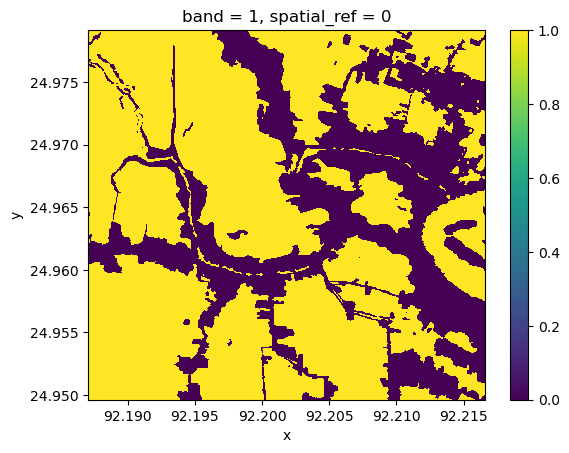

In [66]:
labelRaster.plot()

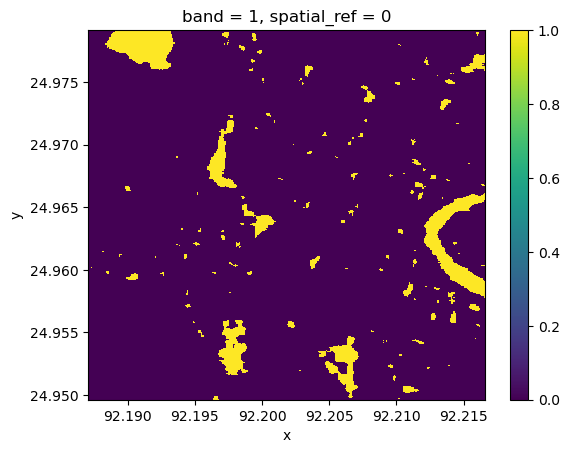

In [81]:
DevriesRasterReproj.plot()